In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [3]:
data1 = pd.read_csv('/content/drive/MyDrive/bjp_tweets.csv')
data2 = pd.read_csv('/content/drive/MyDrive/congress_tweets.csv')
data = pd.concat([data1,data2])
# Keeping only the neccessary columns
data = data[['tweet','target']]
print(data.shape)
data.head()

(79729, 2)


,tweet,target
0,ndtv anchor let go over to aap live press conf...,0
1,sambit patra attacks rahul gandhi over his cow...,0
2,crediting the bjp with taking development to s...,1
3,ktrbrs do do false allegations on iasassociati...,0
4,gujarat assembly yet to get rs cr as gst compe...,1


In [4]:
train, test = train_test_split(data,test_size = 0.1)

Positive words


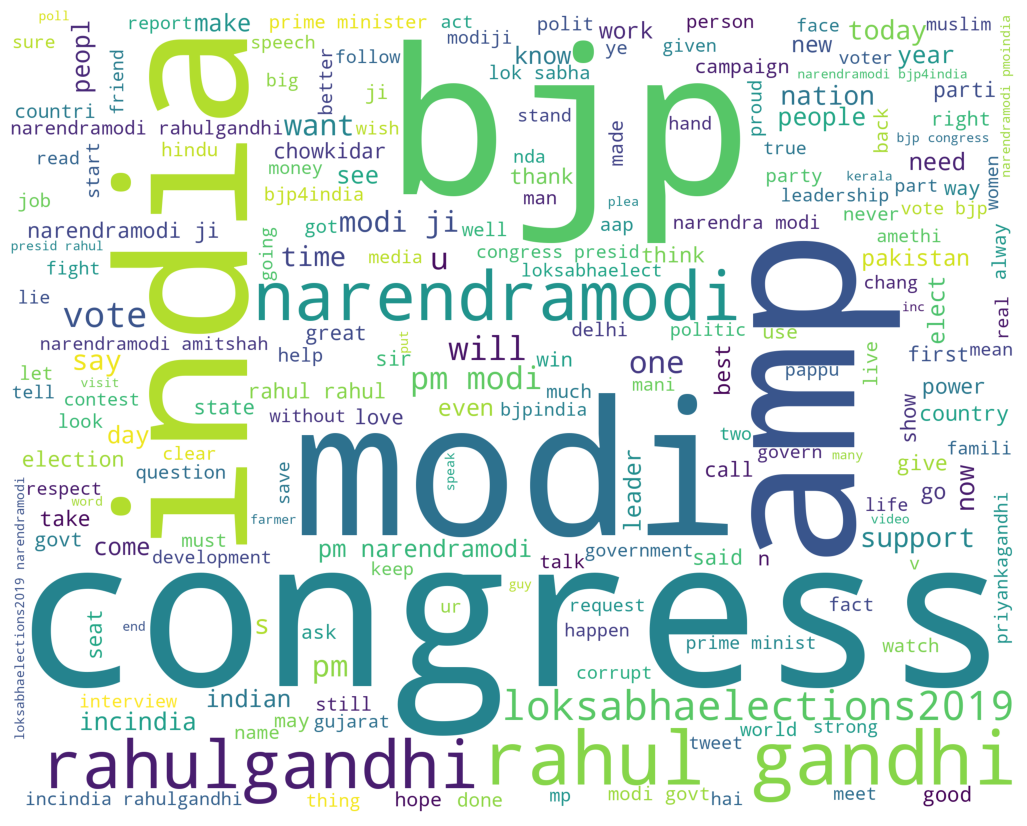

Negative words


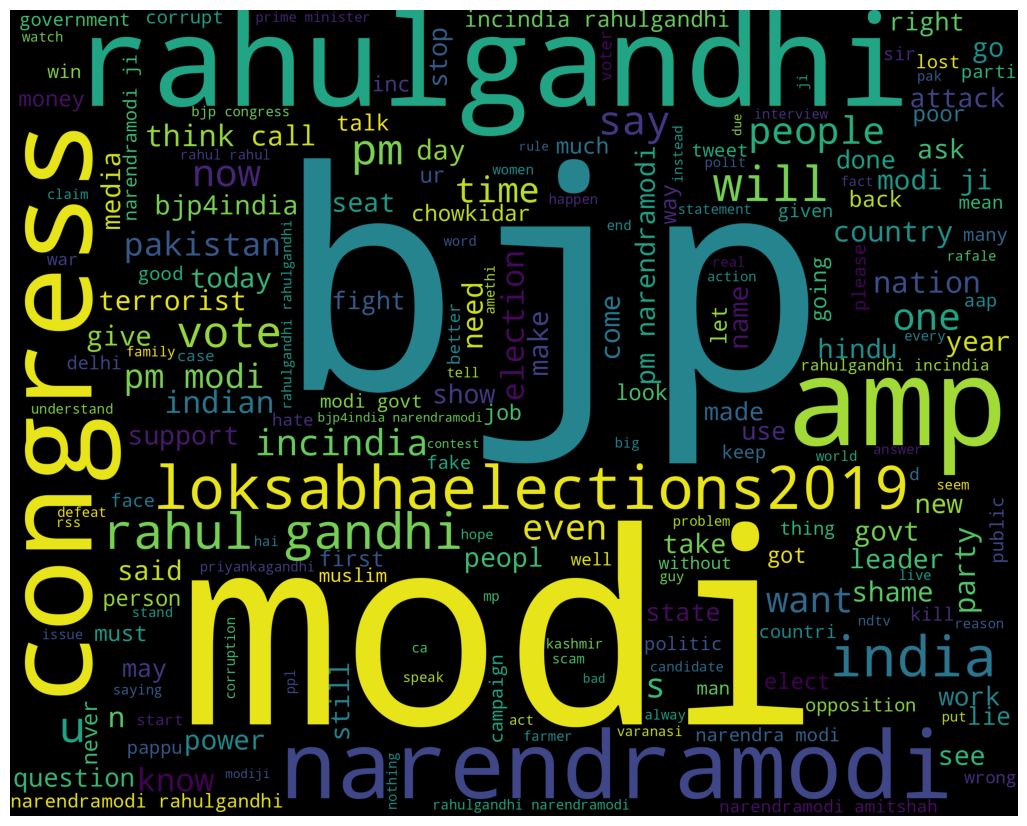

In [5]:
train_pos = train[ train['target'] == 1]
train_pos = train_pos['tweet']
train_neg = train[ train['target'] == 0]
train_neg = train_neg['tweet']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [6]:
print(data[ data['target'] == 1].size)
print(data[ data['target'] == 0].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)

85054
74404


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [7]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 62, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
Y = pd.get_dummies(data['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(53418, 62) (53418, 2)
(26311, 62) (26311, 2)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose = 2)

Epoch 1/10
1670/1670 - 338s - loss: 0.4922 - accuracy: 0.7635 - 338s/epoch - 203ms/step
Epoch 2/10
1670/1670 - 332s - loss: 0.4139 - accuracy: 0.8125 - 332s/epoch - 199ms/step
Epoch 3/10
1670/1670 - 326s - loss: 0.3809 - accuracy: 0.8271 - 326s/epoch - 195ms/step
Epoch 4/10
1670/1670 - 322s - loss: 0.3548 - accuracy: 0.8393 - 322s/epoch - 193ms/step
Epoch 5/10
1670/1670 - 318s - loss: 0.3290 - accuracy: 0.8533 - 318s/epoch - 190ms/step
Epoch 6/10
1670/1670 - 318s - loss: 0.3045 - accuracy: 0.8661 - 318s/epoch - 191ms/step
Epoch 7/10
1670/1670 - 319s - loss: 0.2779 - accuracy: 0.8792 - 319s/epoch - 191ms/step
Epoch 8/10
1670/1670 - 322s - loss: 0.2499 - accuracy: 0.8942 - 322s/epoch - 193ms/step
Epoch 9/10
1670/1670 - 317s - loss: 0.2207 - accuracy: 0.9081 - 317s/epoch - 190ms/step
Epoch 10/10
1670/1670 - 318s - loss: 0.1911 - accuracy: 0.9201 - 318s/epoch - 191ms/step


In [ ]:
#Saving the model
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/models/pt6.h5')

In [ ]:
#Loading the model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/models/pt6.h5')

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

776/776 - 46s - loss: 0.6125 - accuracy: 0.8040 - 46s/epoch - 59ms/step
score: 0.61
acc: 0.80


In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s - 743ms/epoch - 743ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 2

In [ ]:
def preprocess_statement(statement):
    statement = statement.lower()
    statement = statement.replace('rt', '')
    statement = ' '.join([word for word in statement.split()
                          if 'http' not in word
                          and not word.startswith('@')
                          and not word.startswith('#')])
    return statement

def tokenize_and_pad(statement, tokenizer):
    sequence = tokenizer.texts_to_sequences([statement])
    padded_sequence = pad_sequences(sequence, maxlen=X.shape[1])
    return padded_sequence

def predict_sentiment(statement, tokenizer, model):
    preprocessed_statement = preprocess_statement(statement)
    padded_sequence = tokenize_and_pad(preprocessed_statement, tokenizer)
    sentiment_probabilities = model.predict(padded_sequence)[0]
    sentiment = np.argmax(sentiment_probabilities)
    return sentiment, sentiment_probabilities

# Example usage
statement = "The government's handling of the economic crisis has been a complete failure, with skyrocketing inflation and rising unemployment rates, leaving the common people to suffer while politicians enjoy their privileges"
sentiment, probabilities = predict_sentiment(statement, tokenizer, model)
print("Sentiment:", sentiment)
print("Probabilities:", probabilities)

1/1 [==============================] - 0s 448ms/step
Sentiment: 1
Probabilities: [0.25864625 0.7413538 ]
